In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 22 17:25:13 2016

@author: tabacof
"""

# Implements a variational autoencoder as described in Kingma et al. 2013
# "Auto-Encoding Variational Bayes"
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
import numpy as np
import lasagne
import time, shutil, os
import scipy
from scipy.io import loadmat
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import pylab as plt
from read_write_model import read_model, write_model

Using gpu device 1: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
#settings
do_train_model = False
batch_size = 100
num_epochs = 50
model_filename = "mnist_clf"

np.random.seed(1234) # reproducibility

In [3]:
print "Using MNIST dataset"

from keras.datasets import mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x = (train_x.reshape((-1, 784))/255.0).astype(np.float32)
test_x = (test_x.reshape((-1, 784))/255.0).astype(np.float32)

input_var = T.matrix('inputs')
target_var = T.ivector('targets')

Using MNIST dataset


Using Theano backend.


In [4]:
relu = lasagne.nonlinearities.rectify

network = lasagne.layers.InputLayer(shape=(None, 784),input_var=input_var)
l_noise = lasagne.layers.BiasLayer(network, b = np.zeros((784,), dtype = np.float32), shared_axes = 0, name = "NOISE")
l_noise.params[l_noise.b].remove("trainable")
network = lasagne.layers.DenseLayer(l_noise, num_units=1024, nonlinearity=relu)
network = lasagne.layers.dropout(network, p=.5)
network = lasagne.layers.DenseLayer(network, num_units=1024, nonlinearity=relu)
network = lasagne.layers.dropout(network, p=.5)
network = lasagne.layers.DenseLayer(network, num_units=10, nonlinearity=lasagne.nonlinearities.softmax)

In [5]:
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(loss, params, 0.01, 0.9)

test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

train_fn = theano.function([input_var, target_var], loss, updates=updates)

val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

In [6]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [7]:
if do_train_model:
    # Finally, launch the training loop.
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(train_x, train_y, batch_size, shuffle=True):
            tr_inputs, tr_targets = batch
            train_err += train_fn(tr_inputs, tr_targets)
            train_batches += 1

        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(test_x, test_y, batch_size, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  validation accuracy:\t\t{:.2f} %".format(
            val_acc / val_batches * 100))
    write_model([network], model_filename)
else:
    read_model([network], model_filename)

In [27]:
def show_mnist(img, i, title=""): # expects flattened image of shape (3072,) 
    img = img.copy().reshape(28, 28)
    img = np.clip(img, 0, 1)
    plt.subplot(2, 1, i)
    plt.imshow(img, cmap='Greys_r')
    plt.title(title)
    plt.axis("off")

In [28]:
# Adversarial confusion cost function
adv_confusion = lasagne.objectives.categorical_crossentropy(test_prediction, target_var).mean()

# Adversarial regularization
regC = T.scalar()
adv_reg = regC*lasagne.regularization.l2(l_noise.b)
# Total adversarial loss
adv_loss = adv_confusion + adv_reg
adv_grad = T.grad(adv_loss, l_noise.b)

# Function used to optimize the adversarial noise
adv_function = theano.function([input_var, target_var, regC], [adv_loss, adv_grad, test_prediction])

In [29]:
def adv_test(orig_img, adv_label, C, plot = True):
    # Set the adversarial noise to zero
    l_noise.b.set_value(np.zeros((784,)).astype(np.float32))

    _, _, orig_pred = adv_function(test_x[orig_img][np.newaxis, :], [adv_label], C)

    # Initialize the adversarial noise for the optimization procedure
    l_noise.b.set_value(np.random.uniform(-1e-8, 1e-8, size=(784,)).astype(np.float32))

    # Optimization function for L-BFGS-B
    def fmin_func(x):
        l_noise.b.set_value(x.astype(np.float32))
        f, g, _ = adv_function(test_x[orig_img][np.newaxis, :], [adv_label], C)
        return float(f), g.flatten().astype(np.float64)

    # Noise bounds (pixels cannot exceed 0-1)
    bounds = zip(-test_x[orig_img], 1-test_x[orig_img])

    # L-BFGS-B optimization to find adversarial noise
    x, f, d = scipy.optimize.fmin_l_bfgs_b(fmin_func, l_noise.b.get_value().flatten(), bounds = bounds, fprime = None, factr = 10, m = 25)
    l_noise.b.set_value(x.astype(np.float32))
    
    adv_loss, _, adv_pred = adv_function(test_x[orig_img][np.newaxis, :], [adv_label], C)

    if plot:
        plt.figure()
        show_mnist(test_x[orig_img], 1, "Original")
        show_mnist(test_x[orig_img] + x, 2, "Adversarial")
        plt.show()

    return adv_loss, np.linalg.norm(x), test_y[orig_img], np.argmax(orig_pred), np.argmax(adv_pred), adv_pred[0][test_y[orig_img]], adv_pred[0][adv_label]

In [36]:
def orig_adv_dist(orig_img = None, adv_label = None, plot = False):
    if orig_img is None:
        orig_img = np.random.randint(0, len(test_x))
        _, _, pred = adv_function(test_x[orig_img][np.newaxis, :], [0], 0.0)
        print(np.argmax(pred), test_y[orig_img], pred)
        while np.argmax(pred) != test_y[orig_img]:
            orig_img = np.random.randint(0, len(test_x))
            _, _, pred = adv_function(test_x[orig_img][np.newaxis, :], [0], 0.0)
            print(np.argmax(pred), test_y[orig_img], pred)

    if adv_label is None:
        adv_label = test_y[orig_img]
        while adv_label ==  test_y[orig_img]:
            adv_label = np.random.randint(0, 10)

    print "Img",orig_img, "Adv label", adv_label
    
    adv_loss=[]
    adv_norm=[]
    orig_prob=[]
    adv_prob=[]
    adv = []
    
    C = np.logspace(-10, 20, 100, base = 2, dtype = np.float32)
    plot_intersection = plot
    
    for i, c in enumerate(C):
        plot_current = plot and (i == 0 or i == 49)
        od, ad, ol, op, ap, o_prob, a_prob = adv_test(orig_img, adv_label, C=c, plot = plot_current)
        if plot_current:
            print ad, o_prob, a_prob
        if plot_intersection and o_prob >= a_prob:
            adv_test(orig_img, adv_label, C=C[i-1], plot = True)
            plot_intersection = False
            print ad, o_prob, a_prob
        adv_loss.append(od)
        adv_norm.append(ad)
        adv.append(ap == adv_label)
        orig_prob.append(o_prob)
        adv_prob.append(a_prob)
        
    adv_loss = np.array(adv_loss)
    adv_norm = np.array(adv_norm)

    if plot:
        plt.figure()
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if x], [adv_loss[i] for i, x in enumerate(adv) if x], c='red', label = "Adversarial")
        plt.scatter([adv_norm[i] for i, x in enumerate(adv) if not x], [adv_loss[i] for i, x in enumerate(adv) if not x], c='blue', label = "Non-adversarial")
        plt.ylabel("Adversarial cross-entropy")
        plt.xlabel("Distortion")
        plt.title("MNIST")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        plt.figure()
        plt.scatter(adv_norm, adv_prob, c='red', label = "Adversarial")
        plt.scatter(adv_norm, orig_prob, c='blue', label = "Original")
        plt.ylabel("Probability")
        plt.xlabel("Distortion")
        plt.title("MNIST")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        plt.figure()
        plt.scatter(adv_norm, scipy.special.logit(adv_prob), c='red', label = "Adversarial")
        plt.scatter(adv_norm, scipy.special.logit(orig_prob), c='blue', label = "Original")
        plt.ylabel("Logit")
        plt.xlabel("Distortion")        
        plt.title("MNIST")
        plt.legend(loc=3, prop={'size':9})
        plt.show()
        
    return adv_norm, adv_loss, adv_prob, orig_prob

(4, 4, array([[  3.06715395e-17,   1.31443459e-11,   7.52745409e-17,
          1.87555700e-16,   1.00000000e+00,   1.14014218e-14,
          6.33359230e-15,   2.09431625e-10,   6.24878025e-14,
          1.10533094e-09]], dtype=float32))
Img 8709 Adv label 9


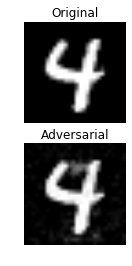

1.67546017344 0.000237754 0.999761


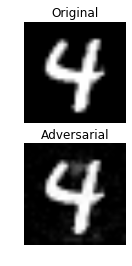

1.12847158207 0.57348 0.426501


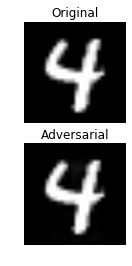

0.312757177013 1.0 3.08193e-07


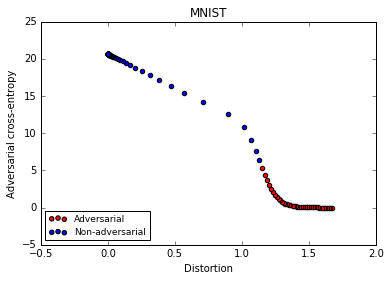

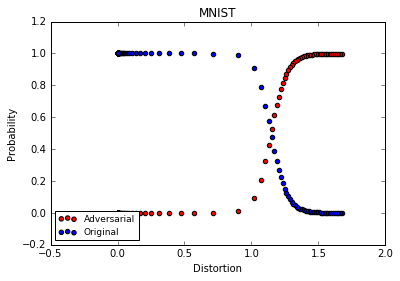

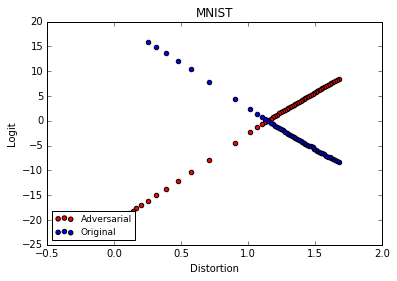

(3, 3, array([[  6.96537295e-17,   9.07680930e-15,   1.02917444e-13,
          1.00000000e+00,   7.91339200e-20,   1.96882875e-12,
          1.76743656e-19,   1.41160842e-11,   8.85085838e-10,
          1.35375313e-11]], dtype=float32))
Img 1127 Adv label 0


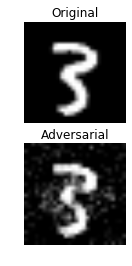

3.47524268481 0.000185138 0.999192


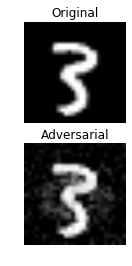

2.45248600905 0.301488 0.263331


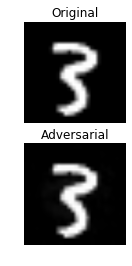

0.356591732652 1.0 1.36421e-13


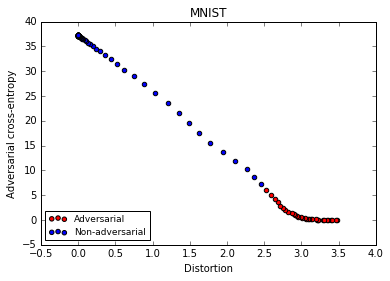

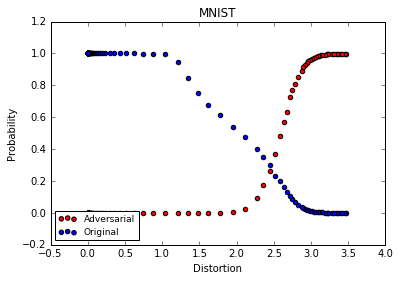

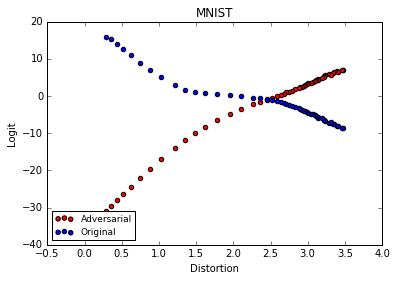

(6, 6, array([[  4.29920306e-07,   2.42266515e-12,   3.41176501e-12,
          2.53772101e-13,   3.34239879e-13,   8.47286537e-06,
          9.99990821e-01,   6.43708787e-14,   2.74102632e-07,
          3.64548436e-09]], dtype=float32))
Img 4882 Adv label 5


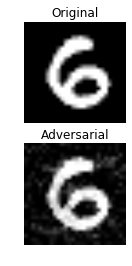

2.5713420862 0.000711189 0.999284


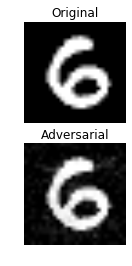

1.56729660627 0.544553 0.454936


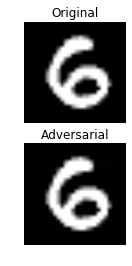

0.130852491152 0.999976 2.27883e-05


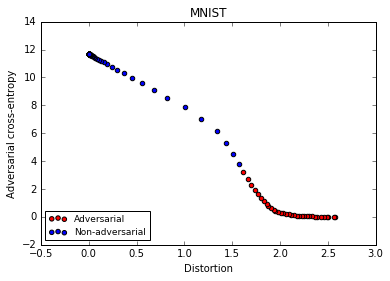

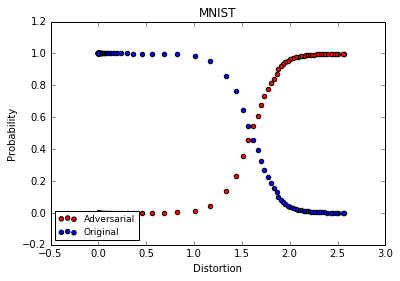

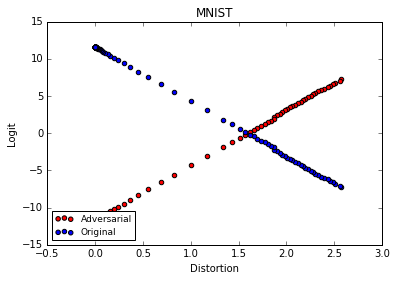

(3, 3, array([[  2.78595224e-12,   6.22815666e-09,   3.21133697e-08,
          9.99998212e-01,   3.66211042e-16,   1.82034955e-06,
          2.45196743e-14,   3.66017841e-11,   8.80544162e-12,
          3.71002257e-10]], dtype=float32))
Img 4393 Adv label 9


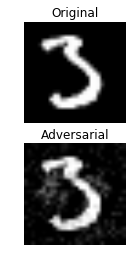

2.5785282073 0.000428623 0.99932


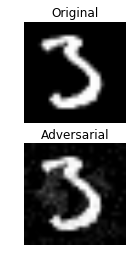

1.73950848244 0.478101 0.475658


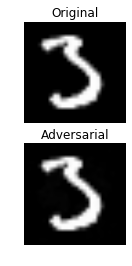

0.228156752284 0.999989 7.89143e-09


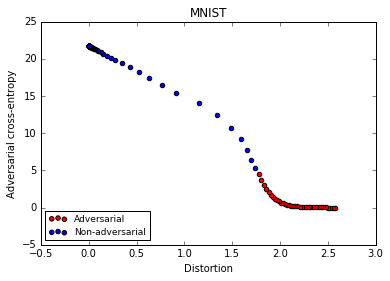

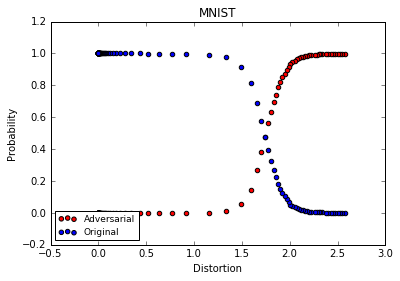

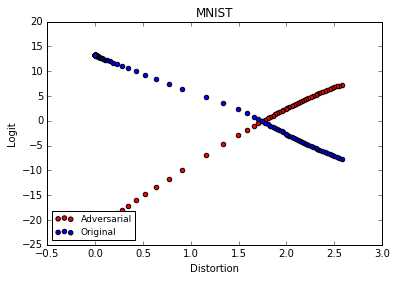

(4, 4, array([[  3.75989828e-14,   2.82884827e-10,   6.75521566e-15,
          7.35895381e-14,   9.99993682e-01,   3.09082482e-11,
          5.36219680e-12,   8.86080098e-09,   3.89795168e-10,
          6.36537288e-06]], dtype=float32))
Img 1043 Adv label 9


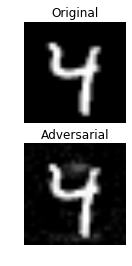

1.2966580762 0.000203946 0.999795


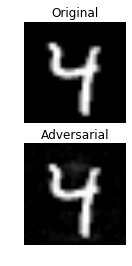

0.70868351588 0.575528 0.424465


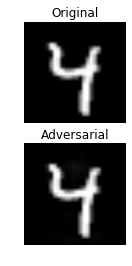

0.276456281501 0.999266 0.000734058


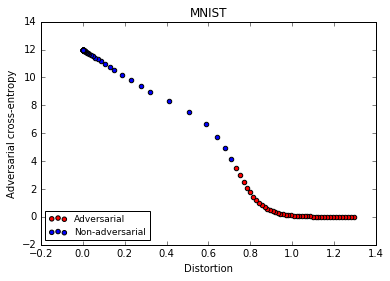

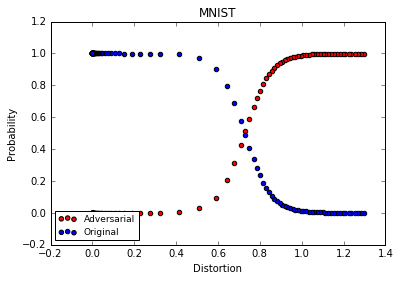

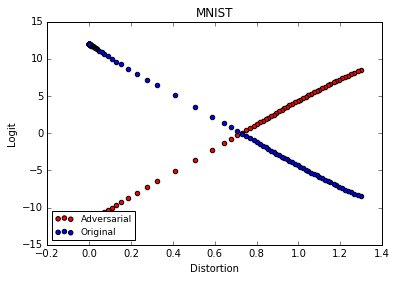

(1, 1, array([[  2.07220404e-11,   9.99995232e-01,   3.19604987e-09,
          2.65528421e-09,   1.44228636e-06,   2.26942176e-09,
          3.85627459e-08,   2.99634826e-06,   3.19948242e-07,
          7.77733378e-10]], dtype=float32))
Img 3784 Adv label 9


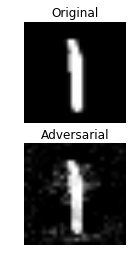

2.13549674469 0.000137703 0.999574


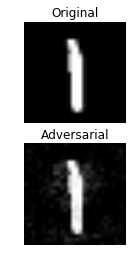

1.39773408832 0.516027 0.347726


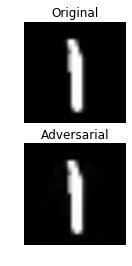

0.263047609699 0.999952 4.48697e-08


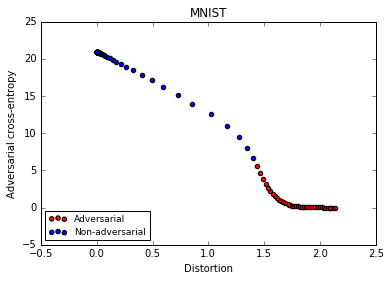

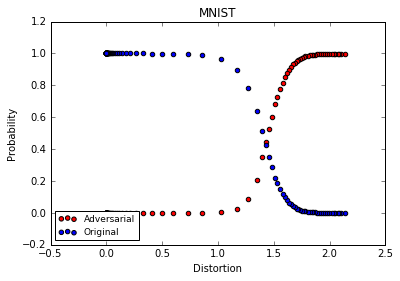

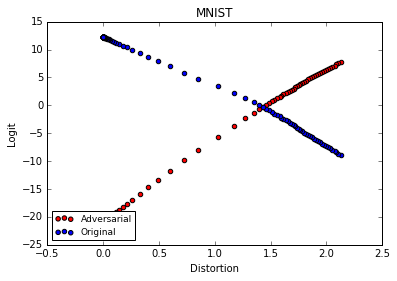

(3, 3, array([[  1.25843537e-11,   7.44676711e-08,   2.22575252e-07,
          9.99990582e-01,   1.20610197e-11,   1.61407387e-10,
          1.41282559e-12,   2.43530349e-06,   6.74643661e-06,
          5.16671648e-08]], dtype=float32))
Img 1066 Adv label 4


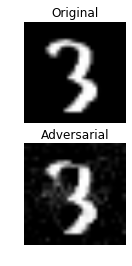

2.06767325867 4.40052e-05 0.999492


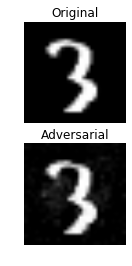

1.1971964375 0.372993 0.238816


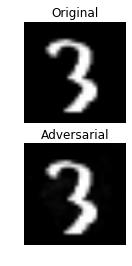

0.387357430864 0.997476 1.20225e-07


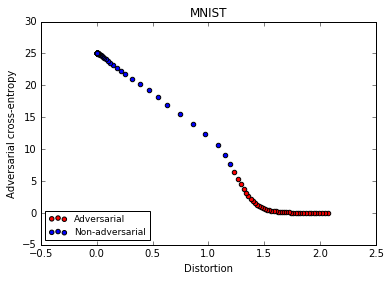

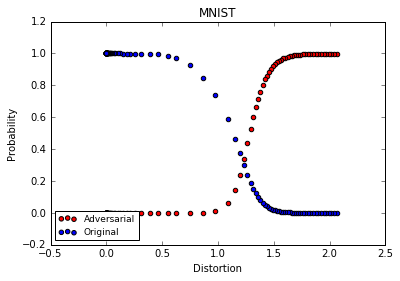

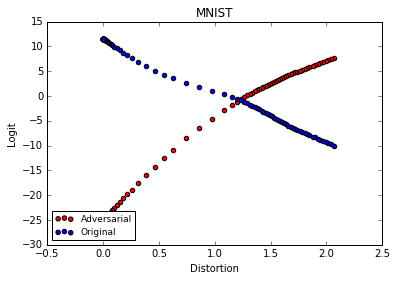

(0, 0, array([[  1.00000000e+00,   4.85228584e-14,   4.44975301e-09,
          7.95130209e-17,   1.92254936e-12,   7.38820782e-16,
          5.94299665e-10,   1.93338470e-11,   9.84617444e-13,
          8.48443449e-09]], dtype=float32))
Img 312 Adv label 6


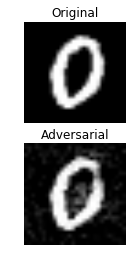

2.56850314242 0.000451742 0.999546


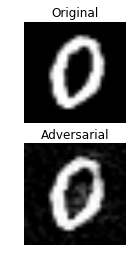

1.91349952523 0.502081 0.497797


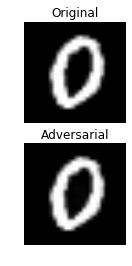

0.178845761508 1.0 3.77781e-09


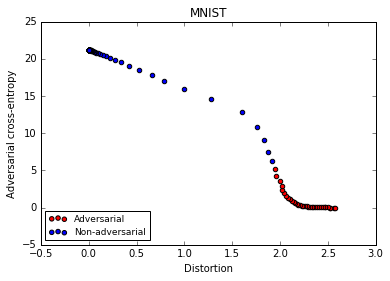

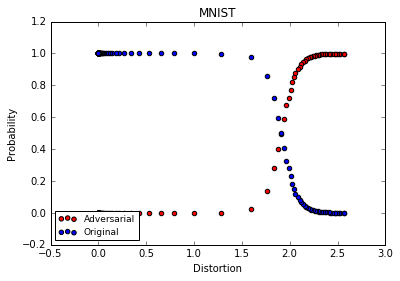

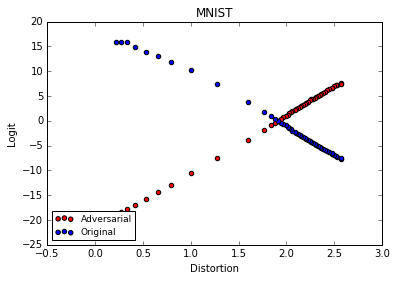

(8, 8, array([[  3.45083934e-10,   6.27812385e-11,   2.30030022e-08,
          1.90499669e-08,   2.65214205e-11,   1.16672709e-05,
          3.81874798e-08,   2.56175081e-10,   9.99987721e-01,
          5.30271905e-07]], dtype=float32))
Img 8297 Adv label 9


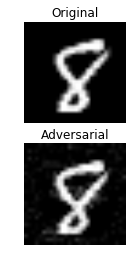

1.9251310237 0.000331184 0.999632


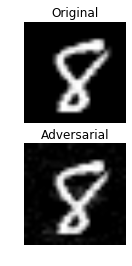

1.24833606498 0.495317 0.490026


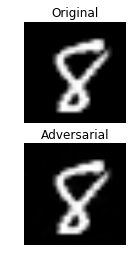

0.206020588918 0.999942 5.97447e-06


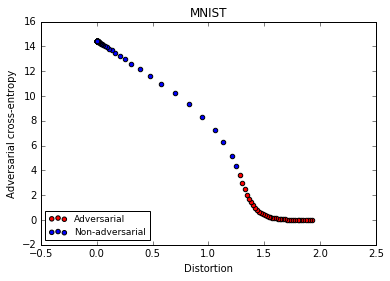

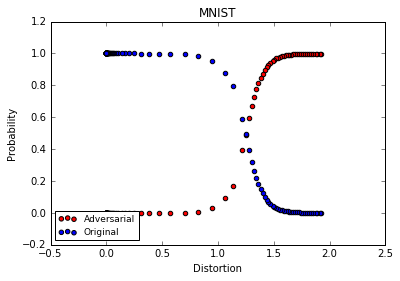

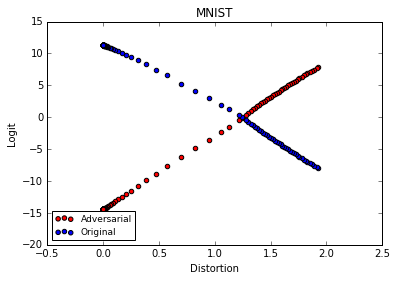

(2, 2, array([[  3.10016298e-06,   8.15019303e-05,   9.99905109e-01,
          6.56989698e-07,   4.18922674e-11,   1.81462276e-08,
          2.47964550e-07,   7.90358081e-06,   1.37236282e-06,
          1.87072816e-10]], dtype=float32))
Img 2429 Adv label 7


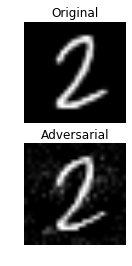

2.11503869286 0.000332081 0.999526


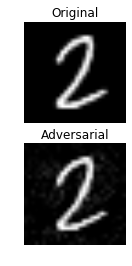

1.26867588533 0.535464 0.410099


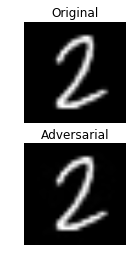

0.160952312654 0.999687 3.71018e-05


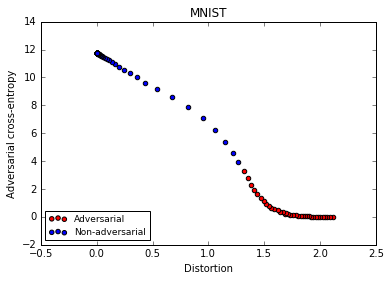

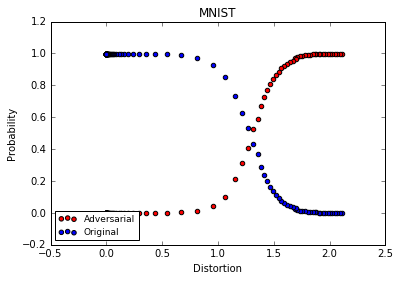

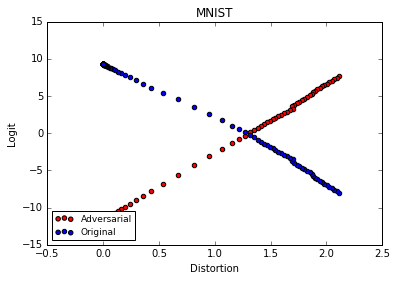

(1, 1, array([[  1.90851241e-12,   9.99998927e-01,   3.08135462e-10,
          4.54682516e-12,   7.82040843e-07,   3.11743374e-11,
          5.17731746e-10,   2.92658456e-07,   2.38767867e-10,
          4.89650074e-12]], dtype=float32))
Img 9878 Adv label 0


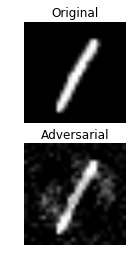

2.84527260023 0.000143289 0.99927


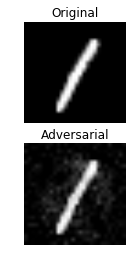

1.91107585624 0.36764 0.307583


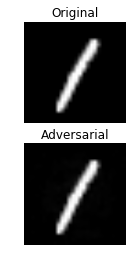

0.270043024884 0.99999 1.46081e-10


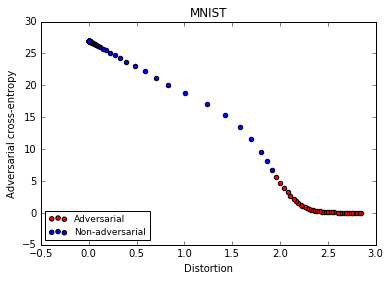

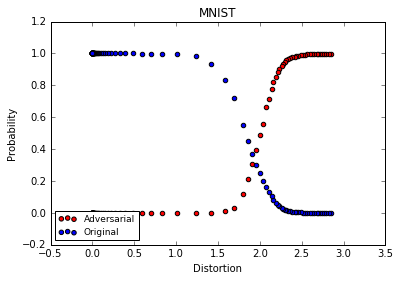

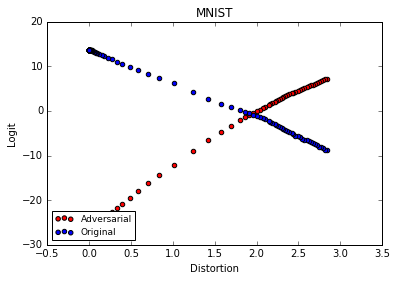

(7, 7, array([[  2.20107044e-09,   7.00113674e-07,   9.56496592e-07,
          1.84770829e-06,   1.52353713e-10,   5.78409846e-12,
          2.47545951e-12,   9.99996185e-01,   2.93103386e-09,
          3.67931477e-07]], dtype=float32))
Img 702 Adv label 3


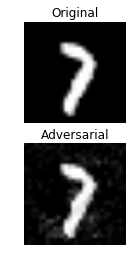

1.800832547 0.000322279 0.99962


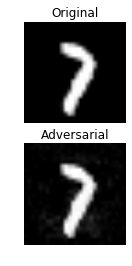

0.960898293025 0.548387 0.421923


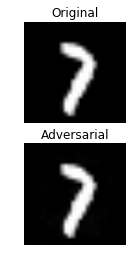

0.234156063614 0.999926 4.58875e-05


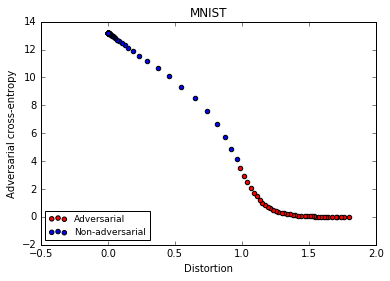

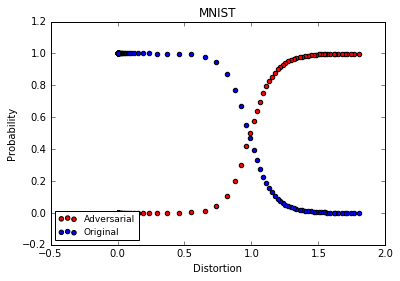

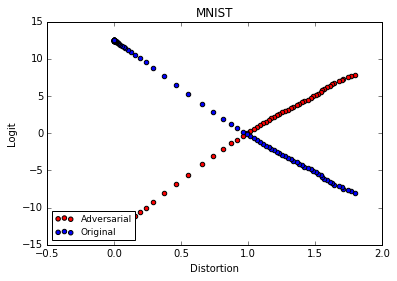

(8, 8, array([[  3.34491915e-07,   3.20983773e-08,   5.18704019e-06,
          6.63597137e-04,   2.41049070e-10,   3.57073434e-02,
          1.01737399e-07,   2.70277224e-06,   9.63596880e-01,
          2.37467866e-05]], dtype=float32))
Img 3674 Adv label 5


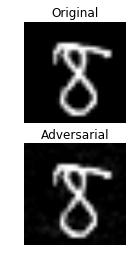

0.965256051302 0.000131048 0.999841


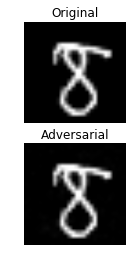

0.258412272872 0.539855 0.458012


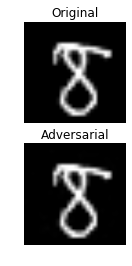

0.1603971978 0.788661 0.209756


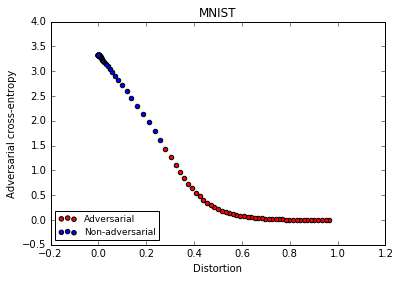

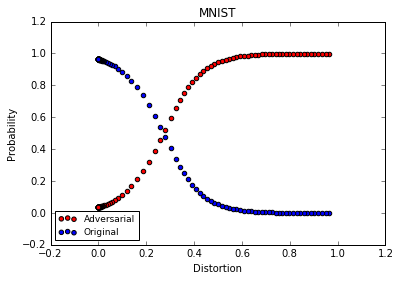

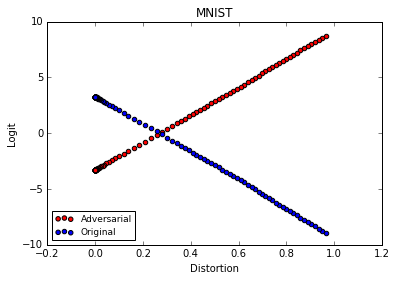

(2, 2, array([[  2.38548115e-09,   8.12772760e-06,   9.99990463e-01,
          1.32678804e-06,   7.86472179e-13,   5.15263665e-11,
          1.85010574e-09,   1.25617603e-07,   2.41687026e-08,
          5.11614514e-13]], dtype=float32))
Img 1658 Adv label 7


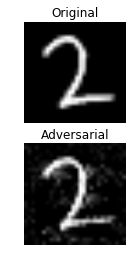

2.53751128388 0.000391523 0.999415


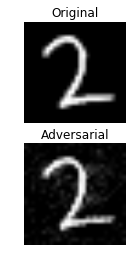

1.6669360923 0.510754 0.414365


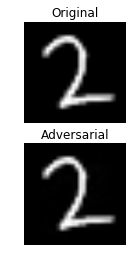

0.174189310338 0.999965 7.35803e-07


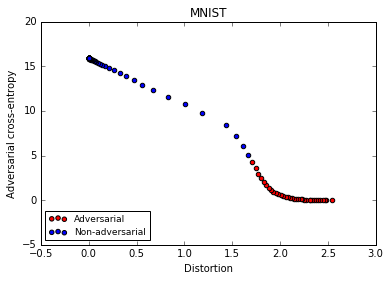

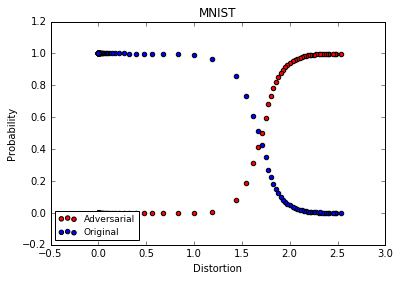

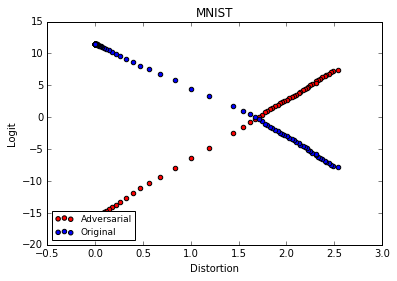

(0, 0, array([[  1.00000000e+00,   3.43087117e-15,   1.50281371e-10,
          5.33036146e-17,   1.12038821e-16,   6.95763239e-16,
          1.96515665e-10,   1.88263955e-13,   2.71452857e-16,
          7.53187372e-15]], dtype=float32))
Img 4958 Adv label 1


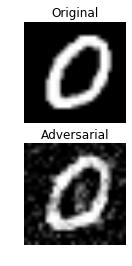

3.8799010974 7.9662e-05 0.998459


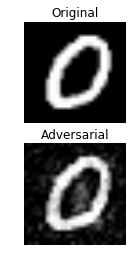

2.81203301641 0.421436 0.327846


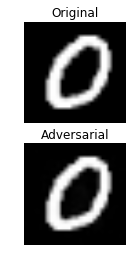

0.222239223425 1.0 6.24033e-14


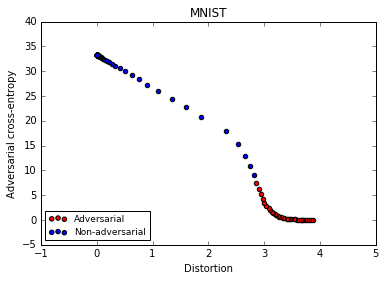

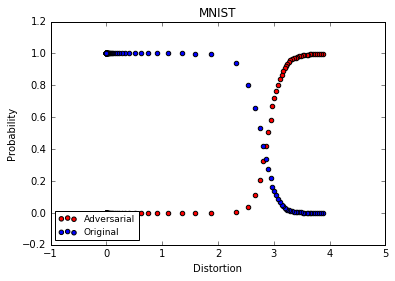

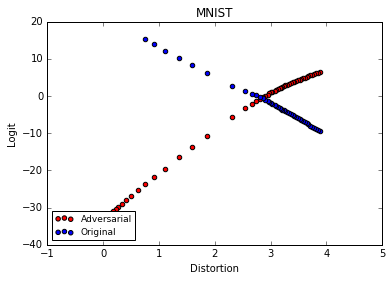

(2, 2, array([[  2.89840015e-20,   4.28036377e-14,   1.00000000e+00,
          5.39136166e-14,   1.90982006e-19,   7.73129271e-19,
          1.27035116e-16,   2.39442781e-17,   4.11988962e-19,
          2.93325694e-26]], dtype=float32))
Img 3933 Adv label 1


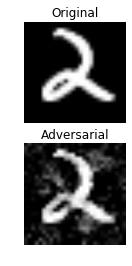

4.04277038231 0.000967495 0.998825


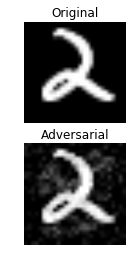

2.83833201787 0.541804 0.440702


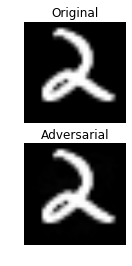

0.222402843096 1.0 8.26651e-13


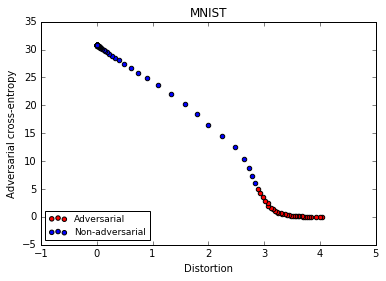

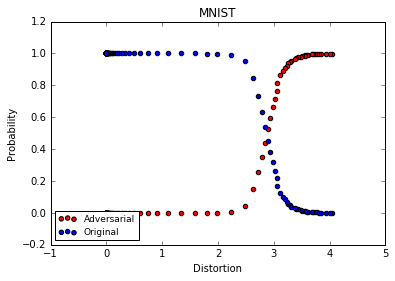

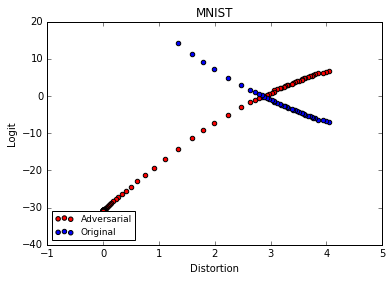

(6, 6, array([[  5.86067062e-09,   2.71468178e-11,   3.28946766e-12,
          3.16753663e-14,   5.48643249e-12,   8.45225614e-08,
          9.99999881e-01,   3.89794059e-14,   1.11441505e-08,
          1.65906270e-13]], dtype=float32))
Img 769 Adv label 1


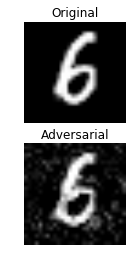

3.2415523121 0.000497773 0.99891


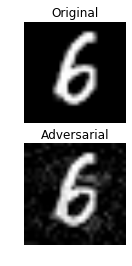

2.17053902233 0.454009 0.338313


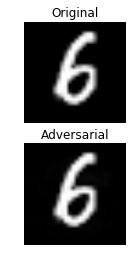

0.241427017052 0.999999 8.22002e-10


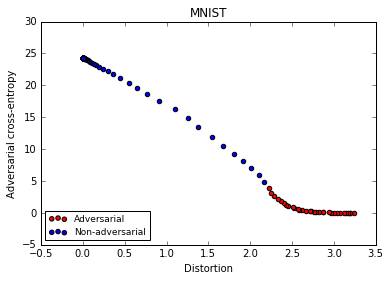

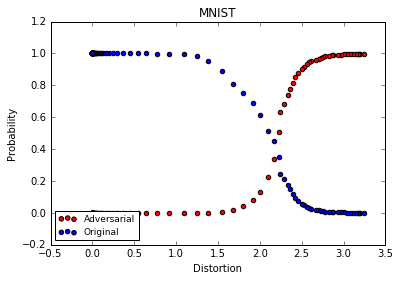

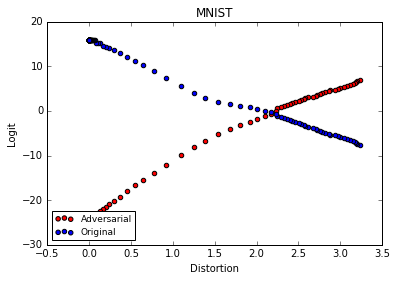

(7, 7, array([[  8.94541873e-14,   3.47483015e-11,   2.25704819e-11,
          1.06585357e-11,   4.72062685e-15,   1.13420363e-14,
          4.09609086e-19,   1.00000000e+00,   1.21982141e-17,
          1.81252680e-10]], dtype=float32))
Img 262 Adv label 5


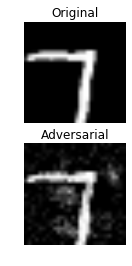

2.95306361387 0.00031351 0.999481


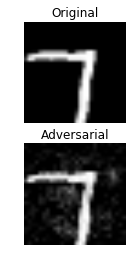

2.22848867122 0.477735 0.433022


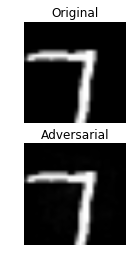

0.288441044178 1.0 1.57965e-12


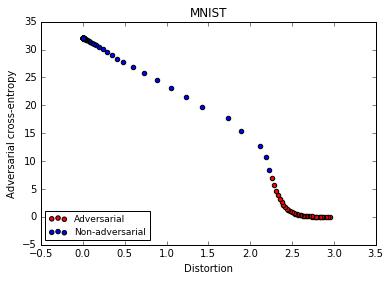

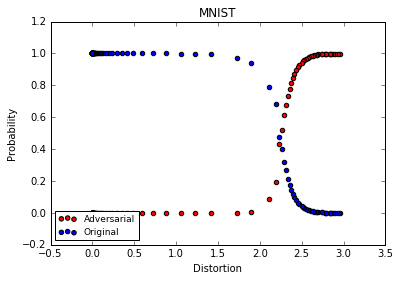

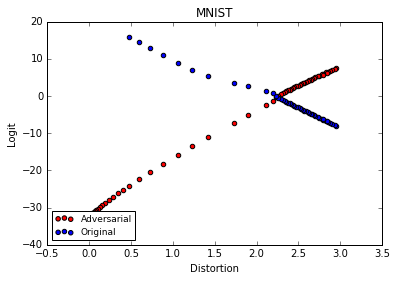

(8, 8, array([[  1.06032579e-10,   1.73487648e-11,   4.19309837e-10,
          1.11339897e-08,   4.54990863e-12,   1.11499432e-09,
          8.65713959e-11,   7.76900592e-12,   1.00000000e+00,
          1.13973186e-08]], dtype=float32))
Img 8618 Adv label 6


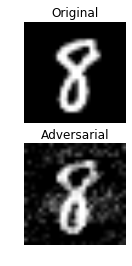

3.75546961844 0.000800991 0.998948


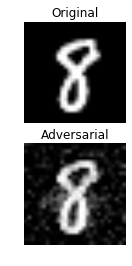

2.96588510556 0.528294 0.425043


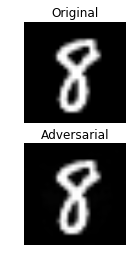

0.188135054096 1.0 7.23408e-10


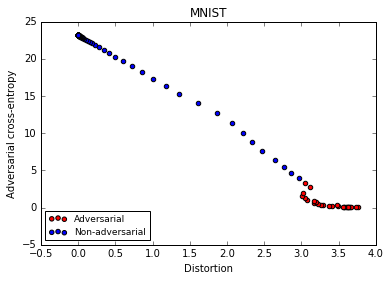

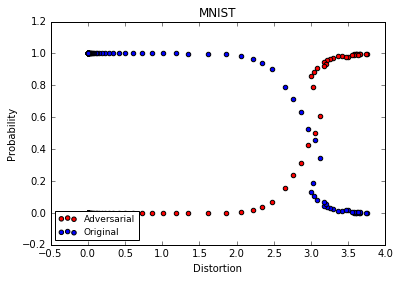

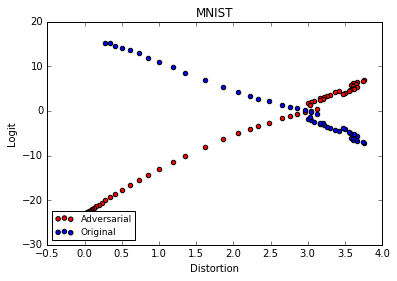

(8, 8, array([[  2.12213927e-11,   3.39019286e-12,   2.75104439e-10,
          4.13197210e-09,   7.00138168e-12,   8.36706306e-07,
          1.22428878e-09,   4.20922498e-12,   9.99999166e-01,
          3.42557342e-08]], dtype=float32))
Img 128 Adv label 0


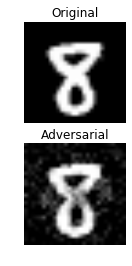

3.54799339635 0.000257294 0.999117


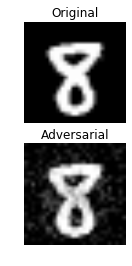

2.92225683243 0.56858 0.331763


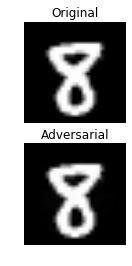

0.208325976736 0.999997 2.77806e-10


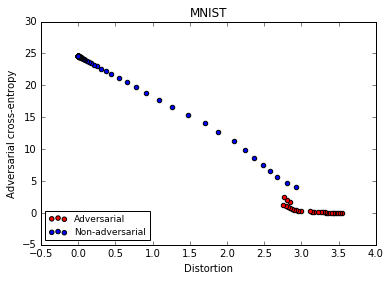

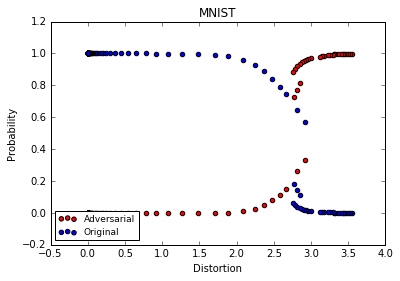

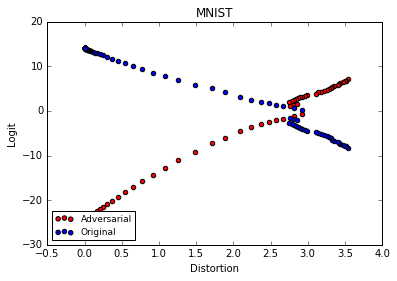

(0, 0, array([[  1.00000000e+00,   5.69130578e-18,   4.39828431e-14,
          2.63041015e-18,   6.81589605e-22,   2.05988425e-13,
          2.36096841e-13,   1.24576905e-14,   5.74946415e-22,
          3.81438184e-19]], dtype=float32))
Img 3584 Adv label 8


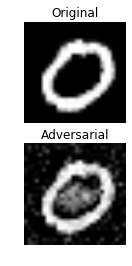

3.9546994329 0.000654218 0.999183


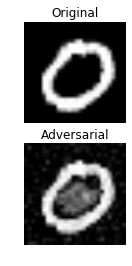

3.32909123122 0.52108 0.466314


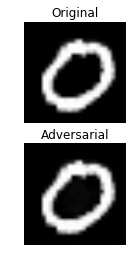

0.296012088802 1.0 9.054e-20


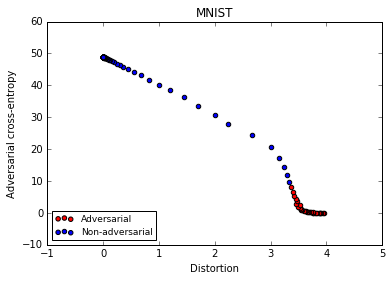

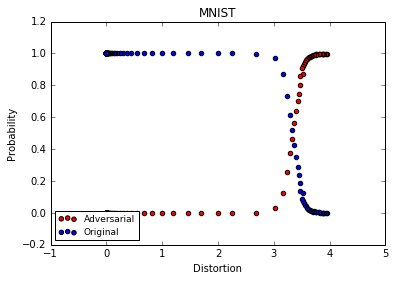

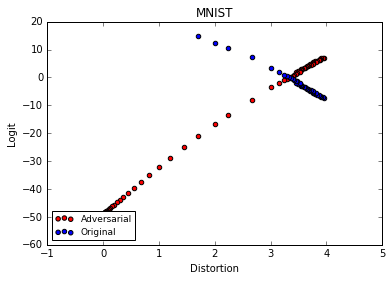

(6, 6, array([[  3.43254044e-13,   6.60197401e-14,   6.74541412e-12,
          2.61492140e-17,   7.23739970e-13,   1.08275910e-09,
          1.00000000e+00,   6.12885247e-18,   1.75043942e-12,
          3.22318569e-17]], dtype=float32))
Img 7824 Adv label 7


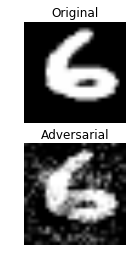

5.04457706457 0.000536164 0.998453


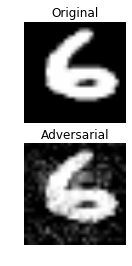

3.33515501777 0.341948 0.251551


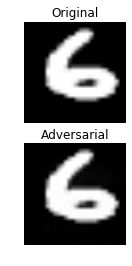

0.273653982987 1.0 5.21397e-16


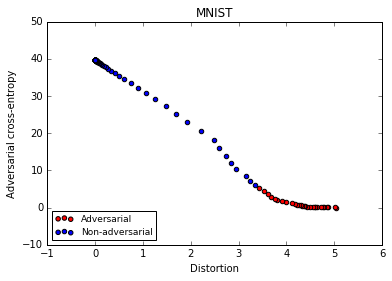

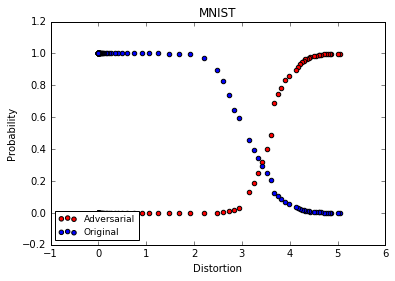

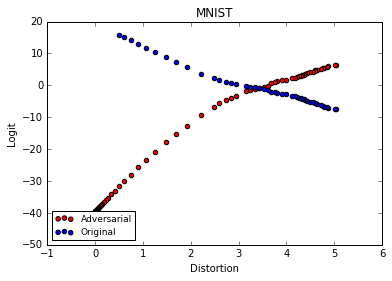

(2, 2, array([[  3.84175655e-05,   4.73663795e-06,   9.99178708e-01,
          5.83124696e-04,   1.09970085e-06,   6.04362649e-05,
          1.29136609e-07,   1.06486877e-04,   4.16439505e-08,
          2.68829826e-05]], dtype=float32))
Img 8245 Adv label 5


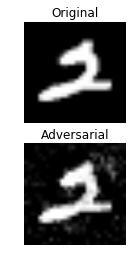

2.17951813879 0.000178825 0.999256


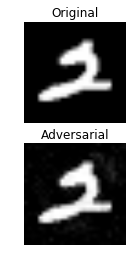

0.909612586241 0.493389 0.343906


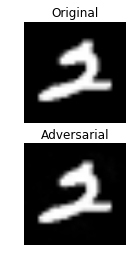

0.187282809893 0.996829 0.000459625


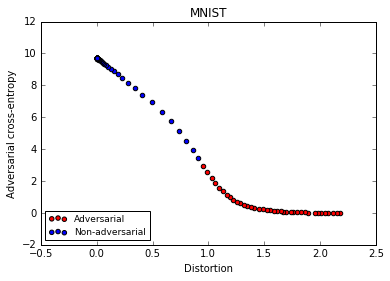

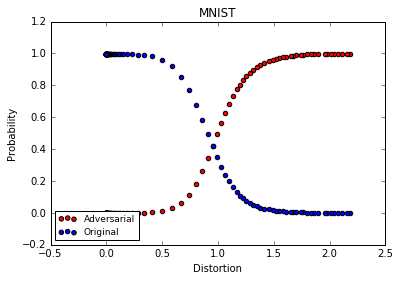

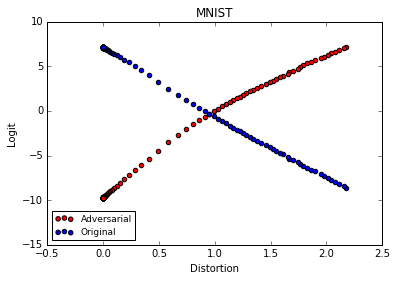

(7, 7, array([[  3.56263526e-11,   3.12477982e-06,   3.84371823e-08,
          2.68076605e-09,   1.06086646e-10,   3.12328531e-11,
          3.81308314e-14,   9.99996781e-01,   5.28790588e-11,
          4.52473531e-10]], dtype=float32))
Img 2577 Adv label 4


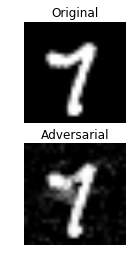

2.28254103581 0.000314579 0.999536


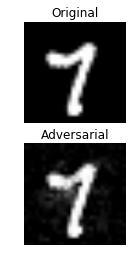

1.55938074261 0.496969 0.394226


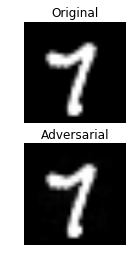

0.287128872959 0.999928 1.18478e-08


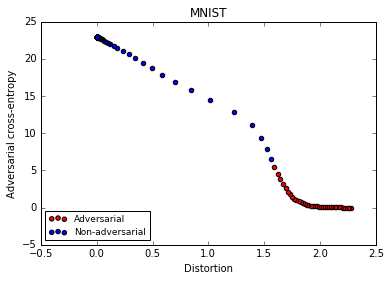

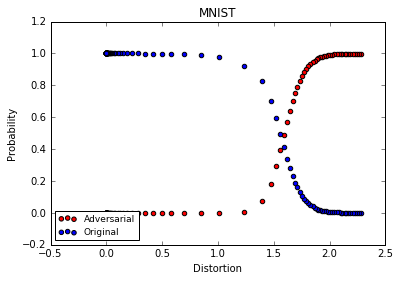

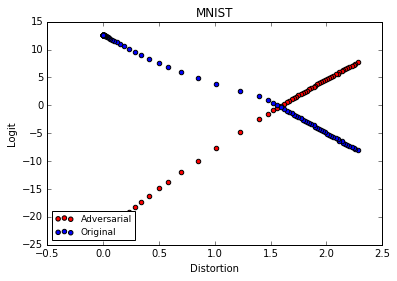

(9, 9, array([[  2.97094016e-10,   9.33483402e-10,   5.69149155e-12,
          7.79039833e-10,   8.72150238e-04,   2.51537391e-09,
          3.11815018e-11,   1.73026256e-05,   7.09953607e-09,
          9.99110520e-01]], dtype=float32))
Img 1311 Adv label 1


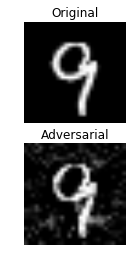

2.99806272216 1.85035e-06 0.998878


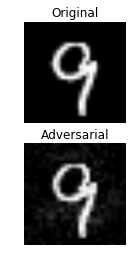

1.49454723704 0.196045 0.116492


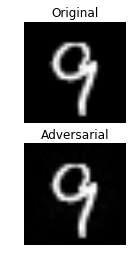

0.291919044109 0.945625 1.6092e-07


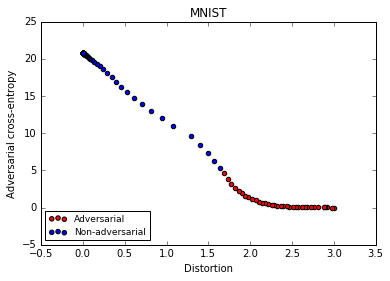

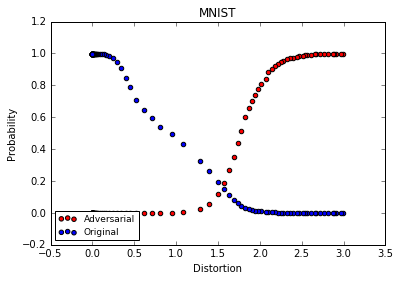

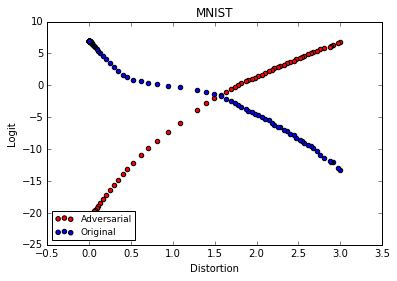

In [38]:
n = 25

adv_norm = []
adv_prob = []
orig_prob = []

for i in range(n):
    an, _, ap, op = orig_adv_dist(plot = True)
    adv_norm.append(an)
    adv_prob.append(ap)
    orig_prob.append(op)
    
adv_norm = np.array(adv_norm)
adv_prob = np.array(adv_prob)
adv_prob_logit = scipy.special.logit(adv_prob)
orig_prob = np.array(orig_prob)
orig_prob_logit = scipy.special.logit(orig_prob)

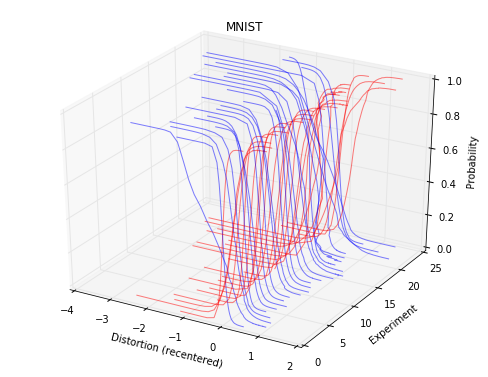

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    intersection = np.argmax((orig_prob[i] - adv_prob[i]) >= 0)
    intersection_x = (adv_norm[i][intersection-1] + adv_norm[i][intersection])/2.0
    intersection_y1 = 0#(adv_prob[i][intersection-1] + adv_prob[i][intersection])/2.0
    intersection_y2 = 0#(orig_prob[i][intersection-1] + orig_prob[i][intersection])/2.0
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), adv_prob[i]-intersection_y1, color = 'r', alpha = 0.5)
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), orig_prob[i]-intersection_y2, color = 'b', alpha = 0.5)

ax.set_xlabel('Distortion (recentered)')
ax.set_ylabel('Experiment')
ax.set_zlabel('Probability')
plt.title("MNIST")
fig.set_figwidth(8.5)
fig.set_figheight(6.5)
plt.show()

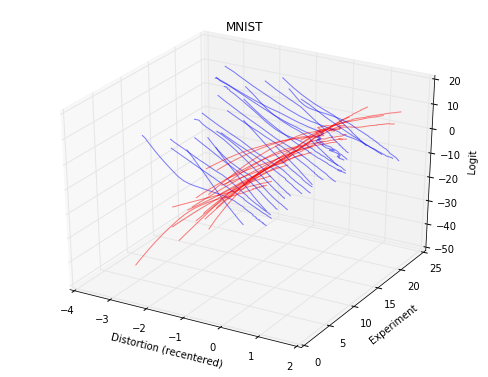

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(n):
    intersection = np.argmax((orig_prob_logit[i] - adv_prob_logit[i]) >= 0)
    intersection_x = (adv_norm[i][intersection-1] + adv_norm[i][intersection])/2.0
    intersection_y1 = 0#(adv_prob_logit[i][intersection-1] + adv_prob_logit[i][intersection])/2.0
    intersection_y2 = 0#(orig_prob_logit[i][intersection-1] + orig_prob_logit[i][intersection])/2.0
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), adv_prob_logit[i]-intersection_y1, color = 'r', alpha = 0.5)
    ax.plot(adv_norm[i]-intersection_x, [i]*len(adv_prob[i]), orig_prob_logit[i]-intersection_y2, color = 'b', alpha = 0.5)

ax.set_xlabel('Distortion (recentered)')
ax.set_ylabel('Experiment')
ax.set_zlabel('Logit')
plt.title("MNIST")
fig.set_figwidth(8.5)
fig.set_figheight(6.5)
plt.show()

Img 40 Adv label 4


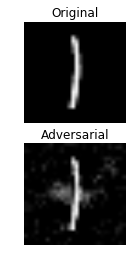

1.93171947898 0.00031458 0.999525


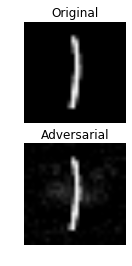

1.0832692479 0.504333 0.465361


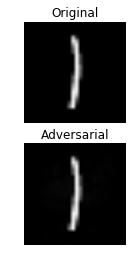

0.250478417914 0.999859 1.30523e-05


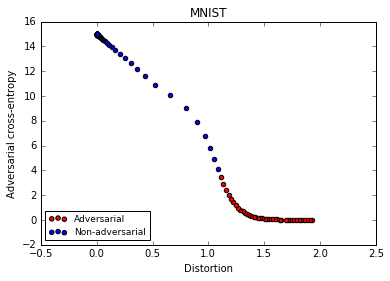

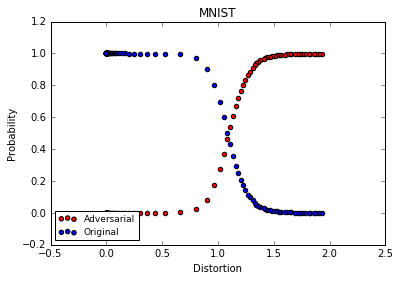

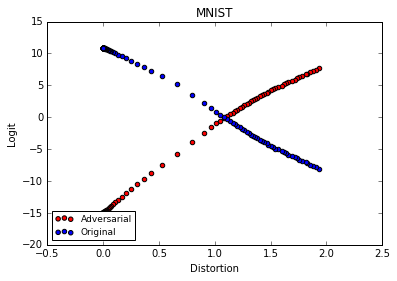

In [37]:
_, _, _, _ = orig_adv_dist(40, 4, plot = True)